In [1]:
import keras
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed, Flatten
from keras.layers import LSTM, GRU, RNN
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from google.colab import files
# upload polution_dataSet.npy file
uploaded = files.upload()
# import data into a dataframe
import io
data = np.load(io.BytesIO(uploaded['polution_dataSet.npy']))

Saving polution_dataSet.npy to polution_dataSet (8).npy


In [0]:
'''
IN this part data for test, validation and train is preperd.
'''
# data format is : pollution  ,dew  ,temp  , press ,wnd_dir , wnd_spd , snow , rain
# total data =43000
# per day and week = 43000/24*7 =250

SAMPLE_DISTANCE = 24      # if 1 sample per hour, if 24 per day, if 24*7 per week
TRAIN_SIZE = 1000
VAL_SIZE = 500
TEST_SIZE = 200
TIMESTEPS = 7             # timesteps used for a single prediction (here each timestep is a day)
HOUR = 2                  # which hour of day ? (0-23) (not so important)

In [0]:
x_train = []
y_train = []
for i in range(TRAIN_SIZE):
    x_train.append(np.array(data[i*SAMPLE_DISTANCE+HOUR:i*SAMPLE_DISTANCE+TIMESTEPS+HOUR]))
    y_train.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS+HOUR, 0]))
x_train = np.array(x_train)
y_train = np.array(y_train)

In [0]:
x_val = []
y_val = []
for i in range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE):
    x_val.append(np.array(data[i*SAMPLE_DISTANCE+HOUR:i*SAMPLE_DISTANCE+TIMESTEPS+HOUR]))
    y_val.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS+HOUR, 0]))
x_val = np.array(x_val)
y_val = np.array(y_val)

In [0]:
x_test = []
y_test = []
for i in range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE):
    x_test.append(np.array(data[i*SAMPLE_DISTANCE+HOUR:i*SAMPLE_DISTANCE+TIMESTEPS+HOUR]))
    y_test.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS+HOUR, 0]))
x_test = np.array(x_test)
y_test = np.array(y_test)
y_total = np.concatenate([y_train, y_val, y_test], axis=None)

In [0]:
'''
In this part network is implemented 
'''
# parameters
BATCH_SIZE = 10
NUM_EPOCHS = 20
HIDDEN_SIZE = 40

In [0]:
# class for RNN Keras
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = K.dot(inputs, self.kernel)
        output = h + K.dot(prev_output, self.recurrent_kernel)
        return output, [output]

In [0]:
# Let's use this cell in a RNN layer:
cell = MinimalRNNCell(HIDDEN_SIZE)

In [0]:
K.clear_session()
# keras modeling
model = Sequential()
model.add(RNN(cell, input_shape=(TIMESTEPS, 8), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  (None, 40)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1, validation_data=(x_val, y_val))

Train on 1000 samples, validate on 500 samples
Epoch 1/20
1000/1000 [==============================] - 0s 393us/step - loss: 0.0409 - val_loss: 0.0167
Epoch 2/20
1000/1000 [==============================] - 0s 201us/step - loss: 0.0170 - val_loss: 0.0159
Epoch 3/20
1000/1000 [==============================] - 0s 202us/step - loss: 0.0158 - val_loss: 0.0133
Epoch 4/20
1000/1000 [==============================] - 0s 218us/step - loss: 0.0140 - val_loss: 0.0129
Epoch 5/20
1000/1000 [==============================] - 0s 206us/step - loss: 0.0142 - val_loss: 0.0157
Epoch 6/20
1000/1000 [==============================] - 0s 176us/step - loss: 0.0137 - val_loss: 0.0163
Epoch 7/20
1000/1000 [==============================] - 0s 180us/step - loss: 0.0138 - val_loss: 0.0134
Epoch 8/20
1000/1000 [==============================] - 0s 195us/step - loss: 0.0134 - val_loss: 0.0135
Epoch 9/20
1000/1000 [==============================] - 0s 189us/step - loss: 0.0134 - val_loss: 0.0138
Epoch 10/20
1000/

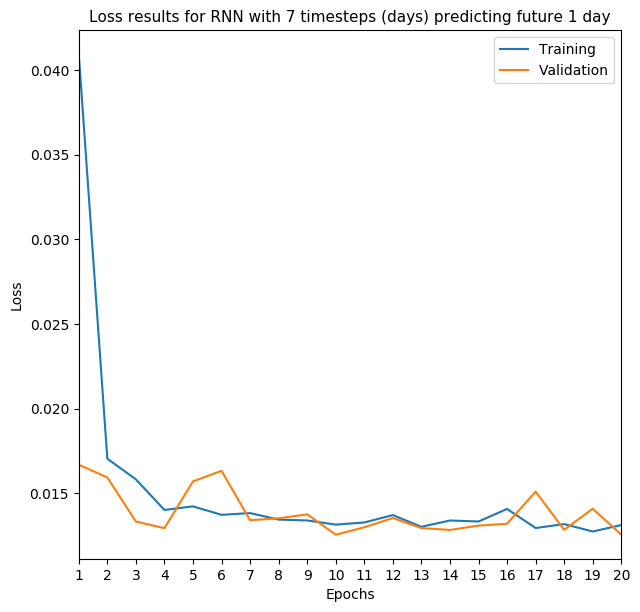

In [13]:
plt.figure(1, figsize=(7, 7), dpi=100)
plt.style.use(['default'])
plt.plot(np.arange(1,NUM_EPOCHS+1,1), history.history['loss'], label='Training')
plt.plot(np.arange(1,NUM_EPOCHS+1,1), history.history['val_loss'], label='Validation')
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1, dtype=int))
plt.xlim(1, NUM_EPOCHS)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss results for RNN with 7 timesteps (days) predicting future 1 day', fontsize=11)
plt.legend()
plt.show()

In [14]:
print('train loss history:', history.history["loss"])
print('test loss history:', history.history["val_loss"])
scores = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print('\nTest result loss: %.3f' % (scores))

train loss history: [0.040943512376397845, 0.017043392383493484, 0.01582158018834889, 0.014012768645770848, 0.014224453149363398, 0.013725698376074433, 0.01382749194279313, 0.013443129947409033, 0.013392336289398373, 0.013146401992999017, 0.013273846614174545, 0.013708866415545345, 0.013017913275398314, 0.013390580606646836, 0.013330686741974206, 0.014073339472524822, 0.012945408103987574, 0.013177494374103845, 0.012739538634195923, 0.01312060077674687]
test loss history: [0.016685864627361296, 0.015931936176493765, 0.013329131370410323, 0.012935919193550945, 0.015699825305491685, 0.01632385576143861, 0.01340646511875093, 0.013516846811398864, 0.01375427708029747, 0.012550594210624695, 0.012989078043028712, 0.01353399901650846, 0.01294191344641149, 0.012832302171736955, 0.013087158272974193, 0.013198460582643748, 0.015095144342631102, 0.01283930161036551, 0.014085800312459469, 0.01255770533811301]
200/200 [==============================] - 0s 130us/step

Test result loss: 0.012


In [0]:
y_train = model.predict(x_train, batch_size=BATCH_SIZE)
y_val = model.predict(x_val, batch_size=BATCH_SIZE)
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)

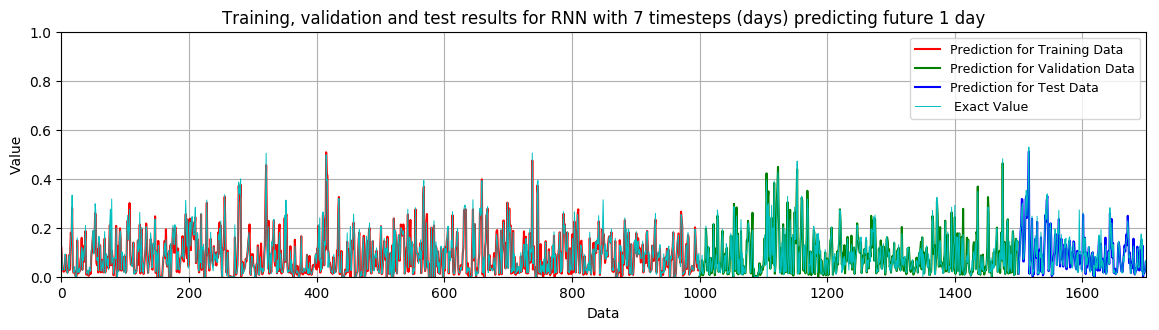

In [16]:
plt.figure(2, figsize=(14, 7), dpi=100)
plt.style.use(['default'])
plt.subplot(211)
plt.plot(range(0, TRAIN_SIZE), y_train, c='r', linewidth=1.5, label='Prediction for Training Data')
plt.plot(range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE), y_val, c='g', linewidth=1.5, label='Prediction for Validation Data')
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_pred, c='b', linewidth=1.5, label='Prediction for Test Data')
plt.plot(range(0, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_total, c='c', linewidth=0.7, label=' Exact Value')
plt.xlim(0, TRAIN_SIZE+VAL_SIZE+TEST_SIZE)
plt.ylim(0, 1)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Training, validation and test results for RNN with 7 timesteps (days) predicting future 1 day')
plt.legend(loc='best', fontsize=9)
plt.grid(True)
plt.show()

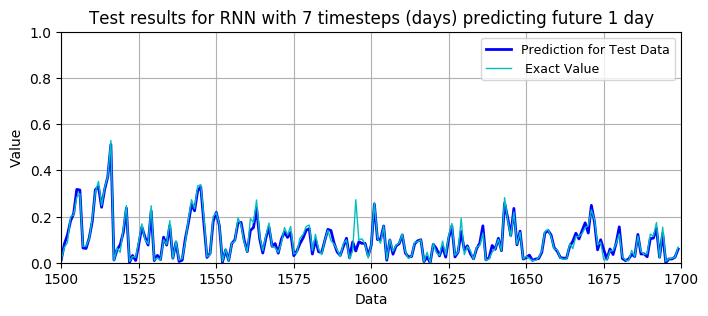

In [17]:
plt.figure(3, figsize=(8, 3), dpi=100)
plt.style.use(['default'])
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_pred, 'b', linewidth=2, label='Prediction for Test Data')
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_total[TRAIN_SIZE+VAL_SIZE:TRAIN_SIZE+VAL_SIZE+TEST_SIZE], c='c', linewidth=1, label=' Exact Value')
plt.xlim(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE)
plt.ylim(0, 1)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Test results for RNN with 7 timesteps (days) predicting future 1 day')
plt.grid(True)
plt.legend(loc='best', fontsize=9)
plt.show()